In [1]:
pip install --quiet --upgrade pip torch torchvision pytorch-lightning wandb matplotlib pillow testresources

Note: you may need to restart the kernel to use updated packages.


## 2 - cut out dices using UNet

Download the inner parts of UNet from: https://github.com/milesial/Pytorch-UNet

In [2]:
# model parts
!wget -q -nc https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/unet/unet_parts.py
!ls -l unet_parts.py

-rw-r--r-- 1 mfa mfa 2602 Feb 18 18:29 unet_parts.py


In [3]:
from PIL import Image
import matplotlib.pyplot as plt

FIXME: add link to train-set and test-set  
(the train-set is the output of `1_prepare_data`)

In [4]:
DATA_DIR = "RESULT_dice-mfa-blue-good"
# DATA_DIR = "/data/dice-CHEAT/RESULT_dice-mfa-blue-good"

In [5]:
!ls RESULT_dice-mfa-blue-good/train

debug  masks


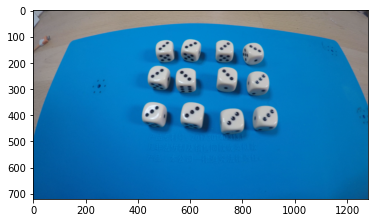

In [6]:
# original image
fn = "G020022_720p.png"
img = Image.open(f"/data/dice-mfa-blue-good/train/{fn}")
plt.imshow(img)
plt.show()

the debug images were used to select the images for training.  
only the ones were all dice had rectangles and no additional false-positive rectangles were on the images, were used.

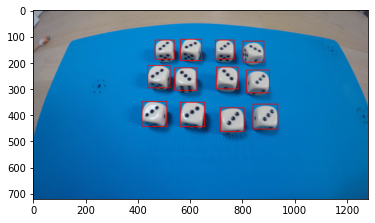

In [7]:
img = Image.open(f"{DATA_DIR}/train/debug/{fn}")
plt.imshow(img)
plt.show()

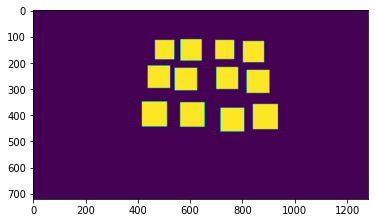

In [8]:
# actual mask for image
img = Image.open(f"{DATA_DIR}/train/masks/{fn}")
plt.imshow(img)
plt.show()

--

In [9]:
import torch
import pytorch_lightning as lightning
lightning.seed_everything(42)

Global seed set to 42


42

In [10]:
from torch.utils.data import DataLoader, random_split, Dataset
from pathlib import Path
import numpy as np

### DataSet

In [11]:
# original from: https://github.com/milesial/Pytorch-UNet/blob/master/utils/data_loading.py

class DiceMaskDataset(Dataset):
    
    def __init__(self, images_dir: str, masks_dir: str, scale: float = 1.0, mask_suffix: str = ''):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        
        self.ids = [i.stem for i in self.images_dir.glob("*png")]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

    def __len__(self):
        return len(self.ids)
    
    @classmethod
    def preprocess(cls, pil_img, scale, is_mask):
        
        w, h = pil_img.size
        
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img_ndarray = np.asarray(pil_img)

        if img_ndarray.ndim == 2 and not is_mask:
            img_ndarray = img_ndarray[np.newaxis, ...]
        elif not is_mask:
            img_ndarray = img_ndarray.transpose((2, 0, 1))

        if not is_mask:
            img_ndarray = img_ndarray / 255

        return img_ndarray

    @classmethod
    def load(cls, filename):
        return Image.open(filename)
        
    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        mask = self.load(mask_file[0])
        img = self.load(img_file[0])

        assert img.size == mask.size, \
            'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale, is_mask=False)
        mask = self.preprocess(mask, self.scale, is_mask=True)

        return (
            torch.as_tensor(img.copy()).float().contiguous(),
            torch.as_tensor(mask.copy()).long().contiguous()
        )

In [12]:
dataset = DiceMaskDataset("/data/dice-mfa-blue-good/train", f"{DATA_DIR}/train/masks")

In [13]:
len(dataset)

836

In [14]:
n_val = int(len(dataset) * 0.05)  # 5% for validation
n_train = len(dataset) - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val])

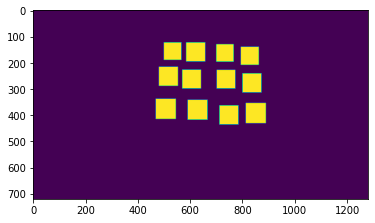

In [15]:
number = 0
plt.imshow(train_ds[number][1])   # .permute(1,2,0).data
plt.show()

In [16]:
train_ds[number][1][100:150, 500:550]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

### test

In [17]:
test_ds = DiceMaskDataset("/data/dice-mfa-blue-good/test", f"{DATA_DIR}/test/masks")

### wandb

In [18]:
import wandb
wandb.login()

wandb: Currently logged in as: mfa (use `wandb login --relogin` to force relogin)


True

### UNet

In [19]:
from unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Model

In [20]:
from torchmetrics import Accuracy

In [21]:
class DiceMaskModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-5):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 1

        self.model = UNet(n_channels=3, n_classes=2, bilinear=True)
        
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)
        
        # FIXME: add accuracy
                
        # if name == "train":
        #     self.train_acc(preds, y)
        #     self.log(f"{name}/acc", self.train_acc)
        # else:
        #     self.valid_acc(preds, y)
        #     self.log(f"{name}/acc", self.valid_acc)
        
        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(val_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(test_ds, batch_size=self.batch_size)

In [22]:
model = DiceMaskModel()
model

DiceMaskModel(
  (model): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [23]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p3--dice-unet", log_model=False)
wandb_logger.watch(model)
# set a device number if the server has more than one GPU
trainer = lightning.Trainer(devices=[0], accelerator="gpu", max_epochs=10, logger=wandb_logger)
trainer.fit(model)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet             | 17.3 M
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.052    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [24]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part3/workshop-p3--dice-unet/3phmwfdf/checkpoints/epoch=9-step=7950.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part3/workshop-p3--dice-unet/3phmwfdf/checkpoints/epoch=9-step=7950.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.01638093590736389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.01638093590736389}]

In [25]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
test/loss,▁
train/loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/loss,█▆▅▄▃▂▂▁▁▁
epoch,9
test/loss,0.01638
train/loss,0.01298
trainer/global_step,7950
val/loss,0.01994


In [26]:
img = val_ds[0][0][None, :]
probs = model(img)
probs = probs.squeeze(0)

In [27]:
probs.size()

torch.Size([2, 720, 1280])

In [28]:
probs.squeeze().detach().numpy()[0]

array([[1.5730861, 1.8390396, 1.9431716, ..., 2.0481095, 1.8665676,
        1.6793176],
       [1.9270728, 2.1141434, 2.0493846, ..., 2.044234 , 2.0389886,
        1.8896676],
       [1.9088112, 2.1087985, 2.0651374, ..., 2.019276 , 2.0540318,
        1.9260333],
       ...,
       [1.9460502, 2.0884376, 2.1037729, ..., 2.0852256, 2.1189883,
        2.0276756],
       [1.8628427, 1.9711294, 2.0031974, ..., 2.0712473, 2.028332 ,
        1.8745203],
       [1.8404188, 2.068513 , 2.1125345, ..., 2.2366364, 2.1055114,
        1.8208967]], dtype=float32)

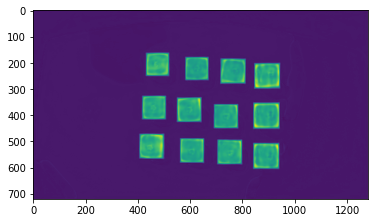

In [29]:
plt.imshow(probs.squeeze().detach().numpy()[1])
plt.show()

In [30]:
mask_bools = probs.squeeze().detach().numpy()[1] > 0.5

In [31]:
mask_bools

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [32]:
mask_img = Image.fromarray((mask_bools * 255).astype(np.uint8))

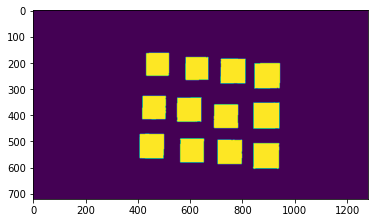

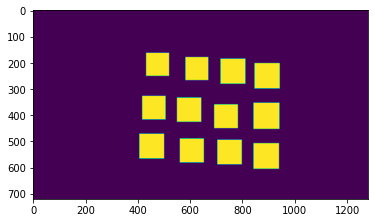

In [33]:
plt.imshow(mask_img)
plt.show()
plt.imshow(val_ds[0][1])
plt.show()

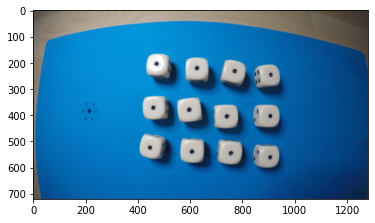

In [34]:
plt.imshow(val_ds[0][0].permute(1,2,0).data)
plt.show()

with test dataset

In [35]:
img = test_ds[0][0][None, :]
probs = model(img)
probs = probs.squeeze(0)

In [36]:
probs.squeeze().detach().numpy()[0]

array([[1.6889766, 1.9286114, 1.9286506, ..., 1.9693888, 1.6988307,
        1.6003642],
       [1.7507867, 1.8140298, 1.7090218, ..., 1.9518017, 1.7617731,
        1.8434957],
       [1.6367859, 1.6936114, 1.7313246, ..., 1.960891 , 1.9076139,
        1.932951 ],
       ...,
       [1.858238 , 1.9510268, 1.932614 , ..., 1.8817313, 1.914202 ,
        2.0664663],
       [1.8376143, 1.9248197, 1.9293666, ..., 1.9132293, 1.829909 ,
        1.8296098],
       [1.8516102, 2.1555545, 2.2277703, ..., 2.2134955, 1.9926877,
        1.8388726]], dtype=float32)

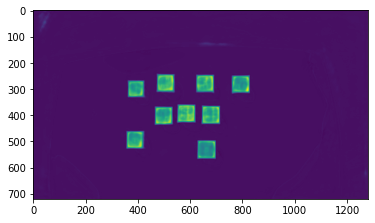

In [37]:
plt.imshow(probs.squeeze().detach().numpy()[1])
plt.show()

In [38]:
mask_bools = probs.squeeze().detach().numpy()[1] > 0.5

In [39]:
mask_img = Image.fromarray((mask_bools * 255).astype(np.uint8))

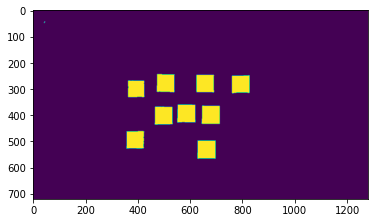

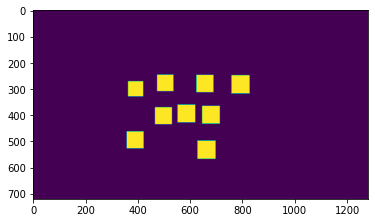

In [40]:
plt.imshow(mask_img)
plt.show()
plt.imshow(test_ds[0][1])
plt.show()

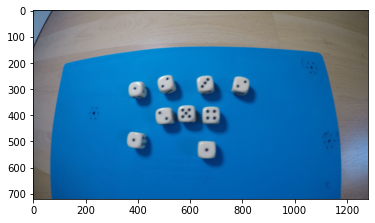

In [41]:
plt.imshow(test_ds[0][0].permute(1,2,0).data)
plt.show()

### generate masks for all images using the model, for use later

In [42]:
import cv2
from tqdm.notebook import tqdm

In [43]:
folder_result = "RESULT_dice-mfa-blue-unet-masks"
# this takes too long, so we only do 2 images -- remove the [:2] to generate all masks
files = list(Path("/data/dice-mfa-blue-good/").glob("*png"))[:2]
for fn in tqdm(files, total=len(files)):
    orig_img = Image.open(str(fn))
    img = dataset.preprocess(orig_img, 1, is_mask=False)
    img = torch.as_tensor(img.copy()).float().contiguous()[None, :]
    probs = model.cpu()(img)
    probs = probs.squeeze(0)
    mask_bools = probs.squeeze().detach().numpy()[1] > 0.5
    mask_img = Image.fromarray((mask_bools * 255).astype(np.uint8))
    mask_img.save(f"{folder_result}/{fn.name}", output="png")

0it [00:00, ?it/s]

generation of all the masks including loading of a pytorch checkpoint is done in  
`2b_process_all_images.py`